In [1]:
get_ipython().magic('matplotlib notebook')
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')
import sys
import numpy as np
import time
import matplotlib.pyplot as plt
import copy as cp

#+____IMPORT FESOM RELATET ROUTINES____________________________________________+
from set_inputarray  import *
from sub_fesom_mesh  import * 
from sub_fesom_mesh  import * 
from sub_fesom_data  import * 
from sub_fesom_plot  import *
from colormap_c2c    import *


In [6]:
#+_____________________________________________________________________________+
#|                                                                             |
#|                         *** LOAD FVSOM MESH ***                             |
#|                                                                             |
#+_____________________________________________________________________________+
# for more options look in set_inputarray.py
inputarray=set_inputarray()
inputarray['save_fig'        ] = False
inputarray['save_figpath'    ] = '/home/ollie/pscholz/figures/poster_TRR181_winterschool/'


# set plot box for cyl projection (default: [-180,180,-90,90])
#inputarray['which_box'] = [0,360,-90,90] ; inputarray['mesh_focus']=180
inputarray['which_box'] = [-180,180,-90,90]
# inputarray['which_box'] = [-180,180,-90,-55]
# dx,dy=5.0,20.0
# inputarray['which_box'] = [0.0-dx,0.0+dx,70.0-dy,70.0+dy]

# set projection variable --> the lon/lat projection plot ranges are set via 
# inputarray['which_box'] = [lonmin,lonmax,latmin,latmax]
# inputarray['proj'     ] = 'cyl' # 'ortho', 'cyl', 'npstere' , 'spstere'
inputarray['proj'     ] = 'cyl'
inputarray['proj_lon' ] = -45 #only for ortho
inputarray['proj_lat' ] = 45 #only for ortho

#inputarray['mesh_id'],inputarray['mesh_dir'] = 'COREv2','/work/ollie/pscholz/mesh_fesom2.0/mesh_CORE2_dsidorenko_meanval/'
inputarray['mesh_id'],inputarray['mesh_dir'], inputarray['mesh_rotate']= 'lofoten','/work/ollie/pscholz/mesh_fesom2.0/lofoten/',False
#inputarray['mesh_id'],inputarray['mesh_dir'],inputarray['mesh_rotate'] = 'fron','/work/ollie/nkolduno/meshes/fron_2.0_RTopo/',False
try:
	mesh
except NameError:
    mesh = fesom_init_mesh(inputarray)
    mesh.fesom_calc_landmask()
else:
    if mesh.id!=inputarray['mesh_id']:
        mesh = fesom_init_mesh(inputarray)
        mesh.fesom_calc_landmask()
    else:
        print(' --> ___FOUND {} FESOM MESH --> will use it!___________________________'.format(mesh.id))   


___LOAD FESOM MESH lofoten_________________________________________
 --> read grid files
     > nod2d.out  : #2dn=288362
     > elem2d.out : #2de=571894
     > aux3d.out
     > nlvls.out
     > elvls.out
 --> remove cyclic boundary
_______________________________________________________________
 --> calc landmask contourline


 --> calc. triangle resolution in km
 --> calc. triangle area m^2 >> time:0.043 s
 --> calc. triangle area on nodes m^2 >> time:0.897 s

___PLOT 2D DATA____________________________________________


<IPython.core.display.Javascript object>


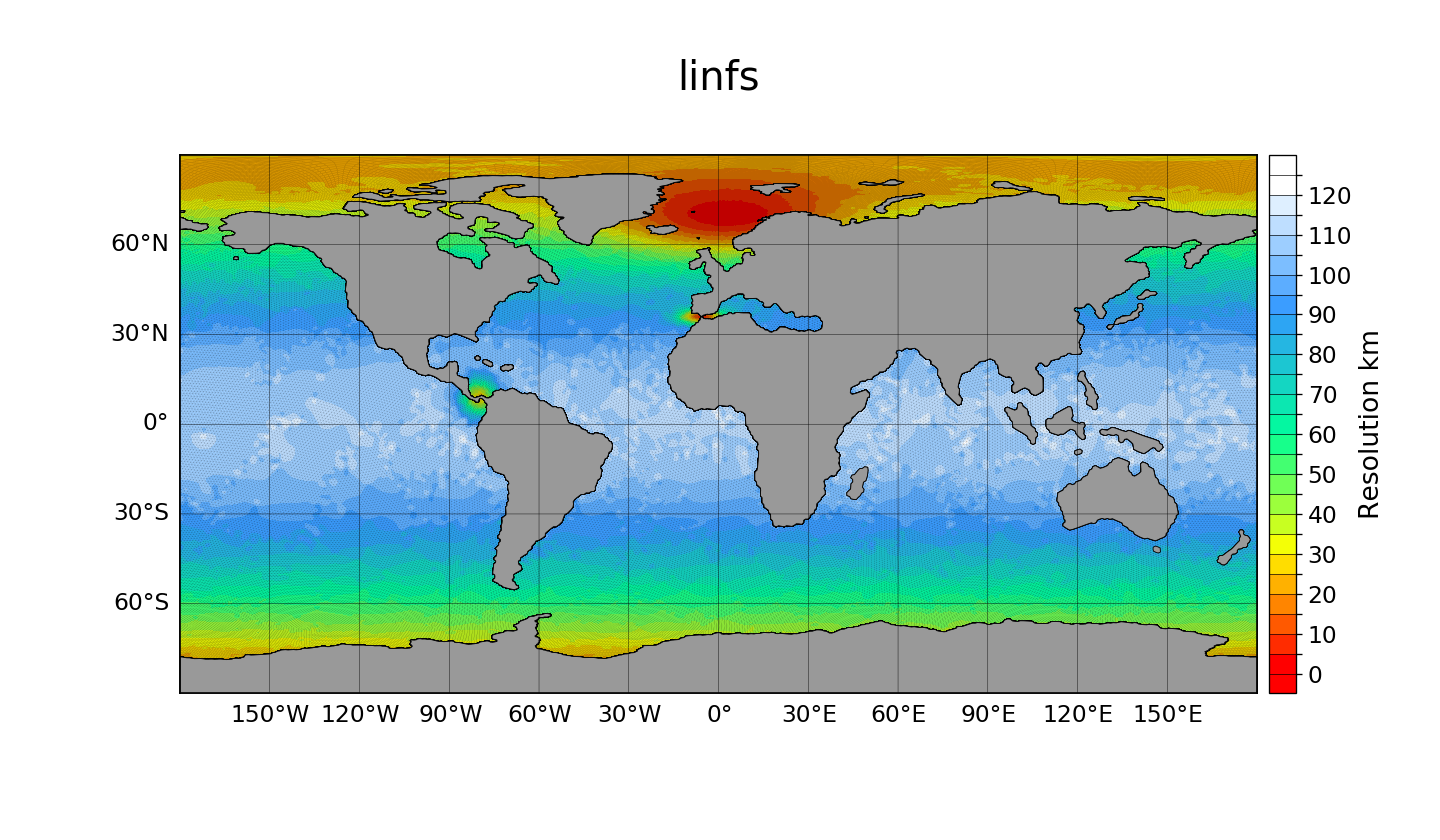

[cmin,cmax,cref] = [0, 121.527505443, 60.0]
clevel =  [   0.    5.   10.   15.   20.   25.   30.   35.   40.   45.   50.   55.
   60.   65.   70.   75.   80.   85.   90.   95.  100.  105.  110.  115.
  120.  125.]


In [7]:
#+_____________________________________________________________________________+
#|                                                                             |
#|                         *** SET INPUT PARAMETER ***                         |
#|                                                                             |
#+_____________________________________________________________________________+
# setup variable name, runid and data path
data 			= fesom_data(inputarray) # init fesom2.0 data object
#data.descript,data.path = 'linfs' ,'/work/ollie/pscholz/results_fesom2.0/linfs/zmeanval/3/'
data.descript,data.path = 'linfs' ,'../results/linfs/kpp/2/'
#data.descript,data.path = 'zlevel' ,'../results/zlevel/1/'
#data.descript,data.path = 'zstar' ,'../results/zstar/3/'
data.var 		= 'triresol'

#+_____________________________________________________________________________+
# select year to average over [start_yr, end_yr]
data.year		= [1998,2007]

# select month to average over
data.month		= [1,2,3,4,5,6,7,8,9,10,11,12]
# data.month		= [9]
# data.record		= [1]

# select linear interpolated depth layers to average over
# data.depth		= [0]
#data.depth		= np.arange(   0, 100+1,10)
data.depth		= np.arange(   0, 200+1,10)
#data.depth		= np.arange( 200, 500+1,20)
#data.depth	    = np.arange( 500,1000+1,50)
#data.depth	    = np.arange(1000,1500+1,50)

#+_____________________________________________________________________________+
# make anomaly
#do_anomaly      = True
do_anomaly      = False
if do_anomaly==True:
    data2 			= cp.copy(data) # init fesom2.0 data object
#     data2.descript,data2.path = 'linfs' ,'../results/linfs/kpp/3/'
#     data2.descript,data2.path = 'linfs-dima' ,'/work/ollie/dsidoren/results/CORE2/fesom2_paper/gm_redi_11/2/'
#     data2.descript,data2.path = 'zlevel_old','/work/ollie/pscholz/results_fesom2.0/failure/zlevel/1/'
    data2.descript,data2.path = 'zlevel_old','/work/ollie/pscholz/results_fesom2.0/failure/linfs/kpp/2/'
    
#+_____________________________________________________________________________+
#|                                                                             |
#|                         *** LOAD FVSOM DATA ***                             |
#|                                                                             |
#+_____________________________________________________________________________+
# plot topography
if data.var=='depth':
    data.value 	= mesh.nodes_2d_zg
    #data.value 	= mesh.nodes_2d_iz
    data.sname, data.lname, data.unit, data.cmap = 'depth', 'Depth', 'm', 'wbgyr'
    data.levels = np.arange(0,np.max(data.value),200)# set resolution levels
#_______________________________________________________________________________
# plot triangle resolution interpolated to node
elif data.var=='triresol':
    if len(mesh.nodes_2d_resol)==0: mesh.fesom_calc_triresol()
    data.value 	= mesh.nodes_2d_resol
    data.sname, data.lname, data.unit, data.cmap = 'triresol', 'Resolution', 'km', 'rygbw'
    data.levels = np.arange(0,np.max(data.value),10)# set resolution levels
#_______________________________________________________________________________
# plot triangle area interpolated to node
elif data.var=='triarea':
    if len(mesh.nodes_2d_area)==0: mesh.fesom_calc_triarea()
    data.value 	= mesh.nodes_2d_area
    data.sname,data.lname, data.unit, data.cmap= 'triarea', 'Area', 'km^2', 'cmocean.cm.balance'
    data.levels = np.arange(0,np.max(data.value),10)# set resolution levels
#_______________________________________________________________________________
# load all other 2d and 3d variables
else:
    fesom_load_data_horiz(mesh,data,do_output='False')
    if data.var.find('MLD')!=-1 : data.value = -data.value;
    #if data.value.size == mesh.n2dea: data.value = mesh.fesom_interp_e2n(np.array(data.value))         
    if do_anomaly==True:
        fesom_load_data_horiz(mesh,data2,do_output='False')
        if data.var.find('MLD')!=-1 : data2.value = -data2.value
        #if data2.value.size == mesh.n2dea: data2.value = mesh.fesom_interp_e2n(np.array(data2.value))
        anom = fesom_data_anom(data2,data)

#+_____________________________________________________________________________+
#|                                                                             |
#|                         *** PLOT FVSOM DATA ***                             |
#|                                                                             |
#+_____________________________________________________________________________+
# plot 2d and 2dvec data
if len(data.value2)==0:
    #___________________________________________________________________________
    # plot anomaly
    if do_anomaly==False:
        #_______________________________________________________________________
        if data.value.size == mesh.n2dea: data.value = mesh.fesom_interp_e2n(np.array(data.value))
        idxbox_e = mesh.nodes_2d_xg[mesh.elem_2d_i].max(axis=1)<inputarray['which_box'][0]
        idxbox_e = np.logical_or(idxbox_e,mesh.nodes_2d_xg[mesh.elem_2d_i].min(axis=1)>inputarray['which_box'][1])
        idxbox_e = np.logical_or(idxbox_e,mesh.nodes_2d_yg[mesh.elem_2d_i].max(axis=1)<inputarray['which_box'][2])
        idxbox_e = np.logical_or(idxbox_e,mesh.nodes_2d_yg[mesh.elem_2d_i].min(axis=1)>inputarray['which_box'][3])
        idxbox_e = idxbox_e==False # true index for triangles that are within box  
        if data.value.size ==mesh.n2dna:
            idxbox_n  = mesh.elem_2d_i[idxbox_e,:].flatten().transpose()
            idxbox_n  = np.array(idxbox_n).squeeze()
            idxbox_n  = np.unique(idxbox_n)
            idx_box   = np.zeros((mesh.n2dna,), dtype=bool)
            idx_box[idxbox_n]=True
            del idxbox_n 
            del idxbox_e
        # case of element data
        elif data.value.size ==mesh.n2dea:
            idx_box   = idxbox_e
            del idxbox_e
        cmin,cmax = np.nanmin(data.value[idx_box]),np.nanmax(data.value[idx_box])
        cref = cmin + (cmax-cmin)/2
        cref = np.around(cref, -np.int32(np.floor(np.log10(np.abs(cref)))-1) ) 
        #cmin,cmax,cref = 1,20,10
        #cmin,cmax,cref = -500,500,0
        #cmin,cmax,cref = -0.25,-0.05,-0.15
        #cmin,cmax,cref = -1.0e-6,1.0e-6,0.0
        #data.crange,data.cmap,data.cnumb = [cmin,cmax,cref],'wbgyr',40
        #data.crange,data.cmap,data.cnumb = [cmin,cmax,0.0],'blue2red',40
        fig,ax,map,cbar,hp1,tri=fesom_plot2d_data(mesh,data,figsize=[12,7],do_grid=True)
    else:
#         #_______________________________________________________________________
#         # interpolate elemental values to nodal vlaues
#         if data.value.size  == mesh.n2dea: data.value  = mesh.fesom_interp_e2n(np.array(data.value))
#         if data2.value.size == mesh.n2dea: data2.value = mesh.fesom_interp_e2n(np.array(data2.value))
#         #_______________________________________________________________________
#         # do common crange for line and lin2
#         cmax = np.max([np.nanmax(data.value),np.nanmax(data2.value)])
#         cmin = np.min([np.nanmin(data.value),np.nanmin(data2.value)])
#         cref = cmin + (cmax-cmin)/2
#         cref = np.around(cref, -np.int32(np.floor(np.log10(np.abs(cref)))-1) ) 
#         data.crange = [cmin,cmax,cref]	
#         data2.crange= [cmin,cmax,cref]
#         #_______________________________________________________________________
#         fig,ax,map,cbar,hp1,tri=fesom_plot2d_data(mesh,data,figsize=[12,7],do_grid=True)
#         fig.canvas.draw()
#         fig,ax,map,cbar,hp1,tri=fesom_plot2d_data(mesh,data2,figsize=[12,7],do_grid=True)
#         fig.canvas.draw()   
        #_______________________________________________________________________
        if anom.value.size  == mesh.n2dea: anom.value  = mesh.fesom_interp_e2n(np.array(anom.value))
        fac = 0.25
        anom.crange= [np.nanmin(anom.value)*fac,np.nanmax(anom.value)*fac, 0.0]
        fig,ax,map,cbar,hp1,tri=fesom_plot2d_data(mesh,anom,figsize=[12,7])
        fig.canvas.draw()
        
else:
    
    fesom_plot2dvec_data(mesh,data,figsize=[12,7])